In [16]:
import numpy as np
import pandas as pd
from pymc_extras.statespace.models import structural as st

import pymc as pm
import arviz as az
import pytensor.tensor as pt

import matplotlib.pyplot as plt

In [2]:
rng = np.random

In [40]:
def simulate_local_level_with_exog(
    n_endog: int = 1,
    time_steps: int = 100,
    mu0: float = 0.0,
    sigma_eta: float = 1.0,
    sigma_eps: float = 0.5,
    beta1: float = 2.0,
    beta2: float = -1.5,
    seed: int | None = None,
):
    """
    Simulates a local level model with exogenous variables.

    Parameters
    ----------
    n_endog: int
        The number of series to simulate
    time_steps: int
        The length of the time-series to simulate
    mu0: float
        The initial state
    sigma_eta: float
        The level innovations standard deviation
    sigma_eps: float
        The observations standard deviation
    beta1: float
        The weight of the binary exogenous variable
    beta2: float
        The weight of the continuous exogenous variable
    seed: int
        Random generator seed for reproducibility

    Returns
    -------
    ys: dict[str, float]
        n_endog number of observations
    mu: float
        latent state
    x1: int
        binary exogenous observations
    x2: float
        continuous exogenous observations
    """
    if seed is not None:
        np.random.seed(seed)

    # init state and observation vectors
    mu = np.zeros(time_steps)
    y = np.zeros(time_steps)

    # initial state
    mu[0] = mu0

    # simulate exogenous variables
    # binary variable
    x1 = np.random.binomial(1, 0.2, size=time_steps)

    # continous variable
    x2 = np.random.normal(0, 1, size=time_steps)

    # simulate latent state (local level)
    for t in range(1, time_steps):
        mu[t] = mu[t - 1] + np.random.normal(0, sigma_eta)

    # simulate observations
    ys = {
        f"y{i+1}": mu + beta1 * x1 + beta2 * x2 + np.random.normal(0, sigma_eps, size=time_steps)
        for i in range(n_endog)
    }

    return ys, mu, x1, x2

In [41]:
# Simulate
T = 100
true_sigma_eta = 0.3
true_sigma_eps = 0.6
true_beta1 = 3.0
true_beta2 = -1.0
ys, mu, x1, x2 = simulate_local_level_with_exog(
    n_endog=3,
    time_steps=T,
    mu0=0,
    sigma_eta=true_sigma_eta,
    sigma_eps=true_sigma_eps,
    beta1=true_beta1,
    beta2=true_beta2,
    seed=42,
)

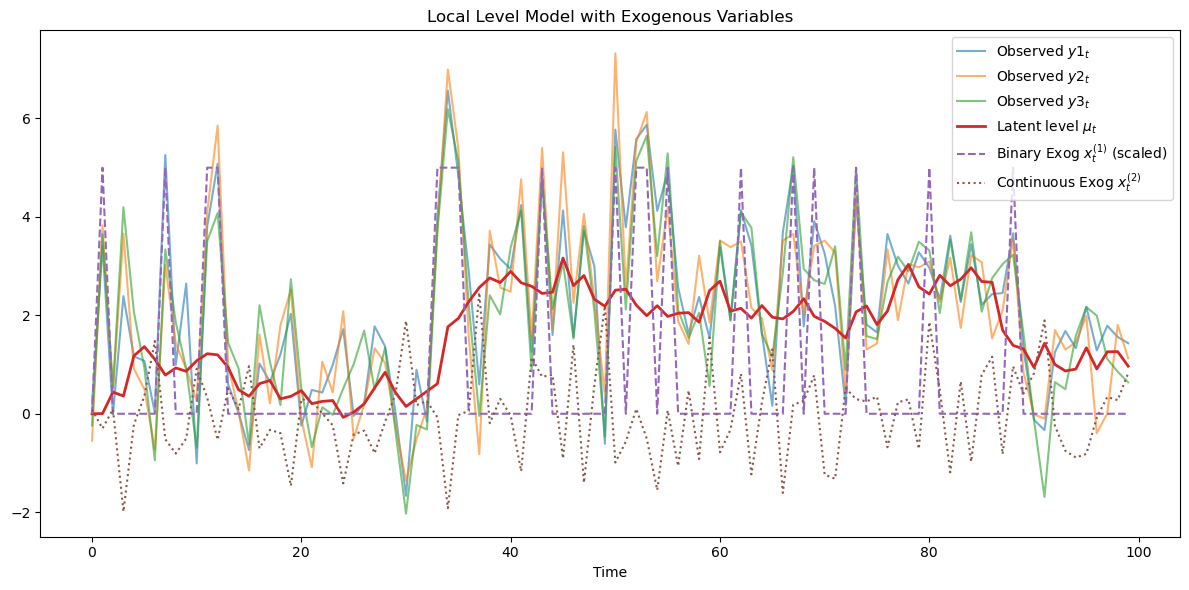

In [ ]:
y = ys["y1"]

# Plot
plt.figure(figsize=(12, 6))
for k, vy in ys.items():
    plt.plot(vy, label=f"Observed ${k}_t$", alpha=0.6)
plt.plot(mu, label="Latent level $\\mu_t$", linewidth=2)
plt.plot(x1 * 5, label="Binary Exog $x^{(1)}_t$", linestyle="--")  # need to blow up to see it
plt.plot(x2, label="Continuous Exog $x^{(2)}_t$", linestyle=":")
plt.legend()
plt.title("Local Level Model with Exogenous Variables")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Quick and dirty test

In [77]:
level_trend = st.LevelTrendComponent(
    order=1, innovations_order=[1], name="level_trend", observed_state_names=["y1", "y2", "y3"]
)

exog = st.RegressionComponent(
    name="exog",
    k_exog=2,
    innovations=False,
    state_names=["x1", "x2"],
    observed_state_names=["y1", "y2", "y3"],
)

ss_mod = (level_trend + exog).build(mode="JAX")

                                  Model Requirements                                   
                                                                                       
  Variable        Shape       Constraints                                  Dimensions  
 ───────────────────────────────────────────────────────────────────────────────────── 
  initial_trend   (3, 1)                               ('trend_endog', 'trend_state')  
  sigma_trend     (3, 1)      Positive                 ('trend_endog', 'trend_shock')  
  beta_exog       (3, 2)                                 ('exog_endog', 'exog_state')  
  P0              (9, 9)      Positive semi-definite           ('state', 'state_aux')  
                                                                                       
  data_exog       (None, 2)   pm.Data                          ('time', 'exog_state')  
                                                                                       
These parameters should be assigned priors inside a PyMC model block before calling the
                            build_statespace_graph method.                             

In [105]:
with pm.Model(coords=ss_mod.coords) as level_trend_exog_model:
    # Data container
    data_exog = pm.Data("data_exog", np.vstack((x1, x2)).T, dims=("time", "exog_state"))

    # Initial process covariance matrix
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=4, dims="state")
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=("state", "state_aux"))

    # Initial local level trend
    initial_trend = pm.Normal("initial_trend", mu=0, sigma=1, dims=("trend_endog", "trend_state"))

    # Local level innovations sigma
    sigma_trend = pm.HalfNormal("sigma_trend", 1, dims=("trend_endog", "trend_shock"))

    # exogenous variable parameter priors
    beta_exog = pm.Normal("beta_exog", 0, 5, dims=("exog_endog", "exog_state"))

    ss_mod.build_statespace_graph(np.vstack((ys["y1"], ys["y2"], ys["y3"])).T)

/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


In [106]:
with level_trend_exog_model:
    idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "JAX", "gradient_backend": "JAX"}
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,10,0.52,7
,2000,10,0.52,7
,2000,87,0.53,7
,2000,4,0.52,7


In [107]:
az.summary(idata, var_names=["beta_exog", "sigma_trend"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_exog[y1, x1]",2.947,0.729,1.433,4.278,0.016,0.014,2232.0,2077.0,1.00
"beta_exog[y1, x2]",-0.991,0.681,-2.270,0.314,0.012,0.014,3102.0,2334.0,1.00
"beta_exog[y2, x1]",3.007,0.713,1.637,4.356,0.015,0.015,2152.0,2107.0,1.00
"beta_exog[y2, x2]",-1.047,0.714,-2.471,0.408,0.014,0.019,3007.0,1644.0,1.00
"beta_exog[y3, x1]",2.800,0.712,1.438,4.165,0.013,0.019,3473.0,2458.0,1.00
"beta_exog[y3, x2]",-0.934,0.675,-2.184,0.426,0.013,0.014,3017.0,2326.0,1.00
"sigma_trend[y1, level]",0.757,0.057,0.657,0.871,0.002,0.002,878.0,367.0,1.01
"sigma_trend[y2, level]",0.927,0.068,0.810,1.062,0.002,0.001,1846.0,1633.0,1.00
"sigma_trend[y3, level]",0.847,0.062,0.733,0.961,0.001,0.001,2009.0,2855.0,1.00


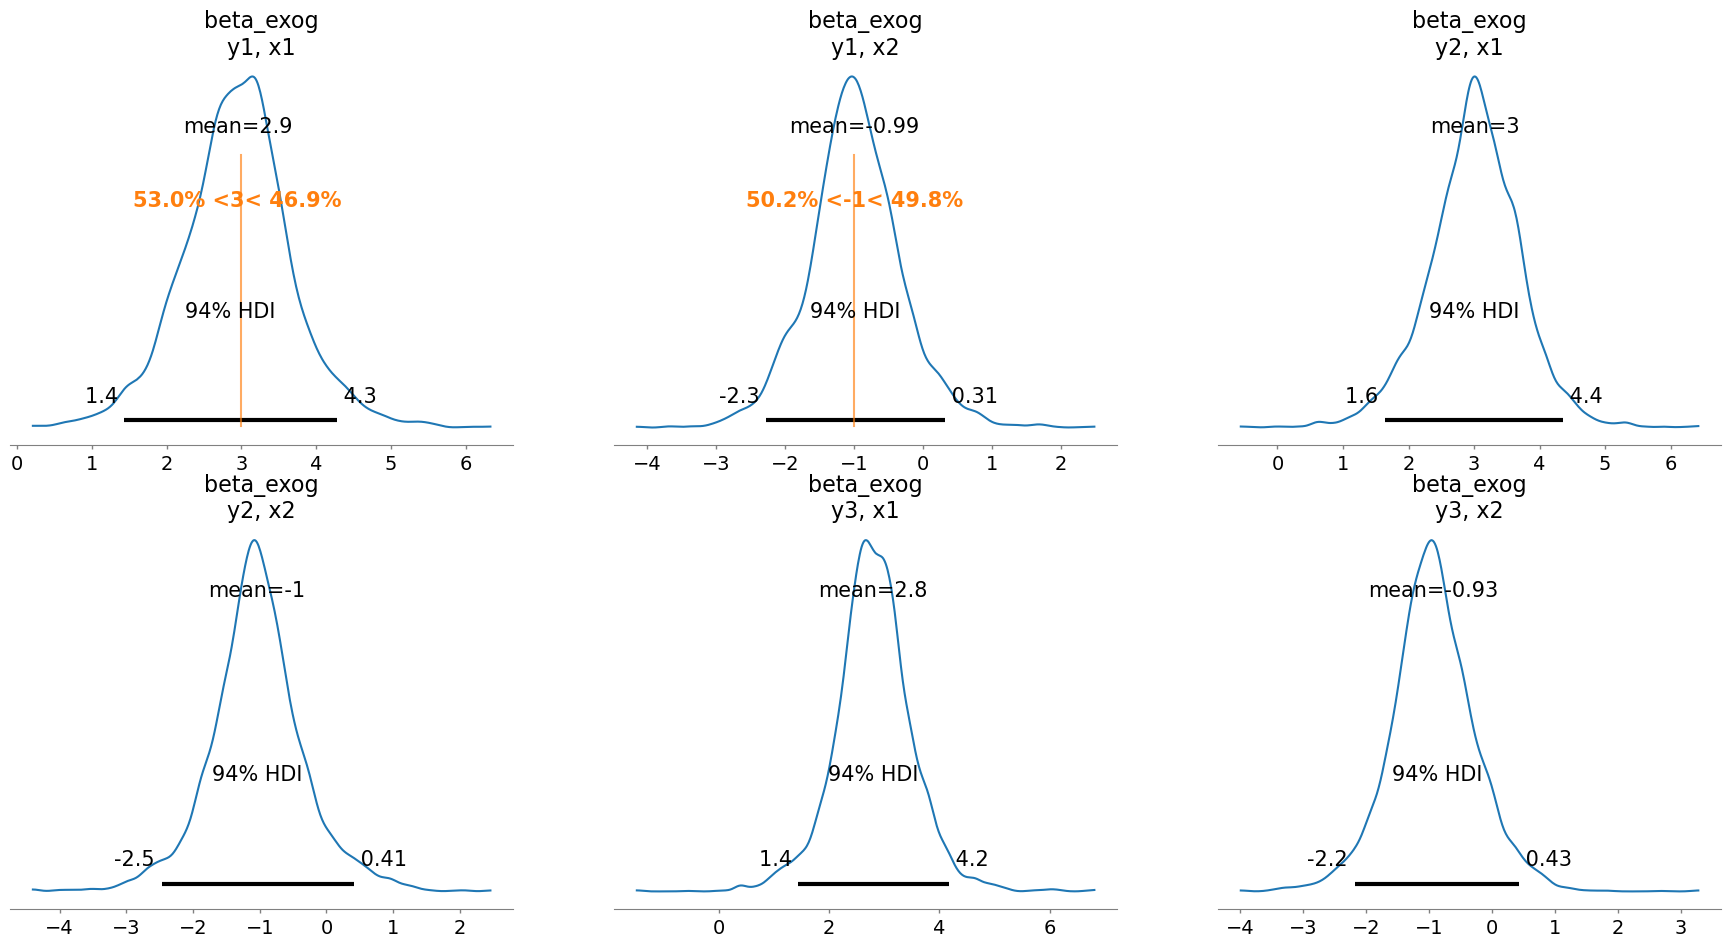

In [108]:
az.plot_posterior(
    idata,
    var_names="beta_exog",
    ref_val={
        "beta_exog": [
            {"exog_endog": "y1", "exog_state": "x1", "ref_val": true_beta1},
            {"exog_endog": "y1", "exog_state": "x2", "ref_val": true_beta2},
        ]
    },
);

# Need to test with missing data